In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal
import pandas as pd

In [92]:
# Function that finds longitude of ec track that corresponds to the provided latitude
def find_ec_lon(lat_sel, ec_lons, ec_lats):
    return ec_lons[np.argmin(np.abs(ec_lats-lat_sel))]

In [93]:
# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 15, 12, 0, 0)
issued_time_str = issued_time.strftime('%Y-%m-%d')

flight_time = datetime(2024, 8, 25, 12, 0, 0)
flight_time_str = flight_time.strftime('%Y-%m-%d')
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print("Initalization date of IFS forecast: " + issued_time_str + "\nFlight date: " + flight_time_str + "\nFlight index: " + flight_index)

Initalization date of IFS forecast: 2024-08-15
Flight date: 2024-08-25
Flight index: HALO-20240825a


In [94]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [95]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(refdate=issued_time_str, reftime=issued_time.hour).to_dask().pipe(egh.attach_coords)

In [96]:
# Load ec satellite track for 
track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-05", kind="LTP").get_track_for_day(flight_time_str)
track = track.sel(time=slice(flight_time_str + " 06:00", None))
ec_lons, ec_lats = track.lon.values, track.lat.values

**Waypoint definitions**

In [97]:
# Mass flux circle radius (m)
radius = 130e3
atr_radius = 70e3

In [98]:
# Setting region (Cabo Verde vs. Barbados)
band = "east"
airport = sal if band == "east" else bco

In [99]:
# Latitudes where we enter ec track (visually estimated)
lat_north = 15.0
lat_south = 4.0

In [100]:
# ITCZ edges visually estimated from iwv contours
lat_edge_south = 4.5
lat_edge_north = 15.0

In [101]:
# Setting lat/lon coordinates

# Points where we get on ec track
north_ec = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), fl = 430, label = "north_ec")
south_ec = LatLon(lat_south, find_ec_lon(lat_south, ec_lons, ec_lats), fl = 430, label = "south_ec")

# Intersection of ITCZ edges with ec track
circle_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), fl = 430, label = "circle_north")
circle_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), fl = 430, label = "circle_south")

# Center of middle circle
center = circle_south.towards(circle_north).assign_label("center")

# Define flight track, can be split into different legs
leg_south = [
     airport, 
     north_ec,
     south_ec
]

leg_circles = [
     IntoCircle(circle_south, radius, 360),   
     IntoCircle(circle_center, radius, 360), 
     IntoCircle(circle_north, radius, 360),
]    

leg_home = [
     north_ec,
     airport
]

waypoints = leg_south + leg_circles + leg_home 

waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

path = fp.expand_path(waypoints, dx=10e3)

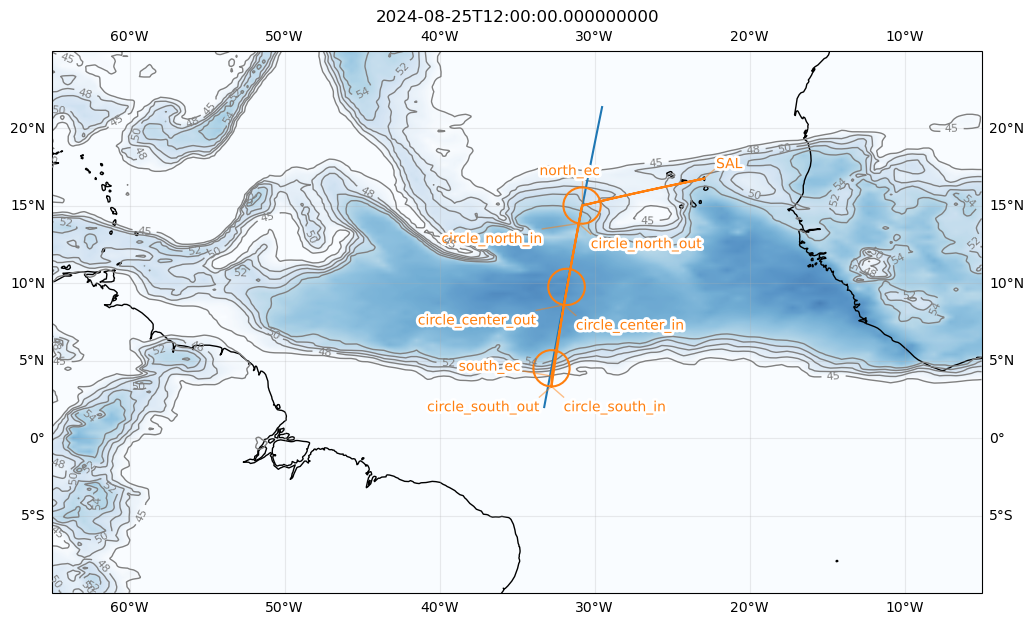

In [102]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [45.0, 48.0, 50.0, 52.0, 54.0])
plt.title(cwv_flight_time.time.values)

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

In [103]:
pd.DataFrame.from_records(map(asdict, [north_ec, circle_north, circle_center, circle_south, south_ec])).set_index("label")

,lat,lon,fl
label,,,
north_ec,15.000000,-30.807100,430.0
circle_north,15.000000,-30.807100,430.0
circle_center,9.752228,-31.808062,NaN
circle_south,4.500000,-32.778100,430.0
south_ec,4.000000,-32.778100,430.0


In [104]:
pd.DataFrame.from_records(map(asdict, waypoint_centers)).set_index("label")

,lat,lon,fl
label,,,
SAL,16.734488,-22.943974,0.0
north_ec,15.000000,-30.807100,430.0
south_ec,4.000000,-32.778100,430.0
circle_south,4.500000,-32.778100,430.0
circle_center,9.752228,-31.808062,NaN
circle_north,15.000000,-30.807100,430.0
north_ec,15.000000,-30.807100,430.0
SAL,16.734488,-22.943974,0.0


In [105]:
points_fx_DM = []
points_fx_DMmm = []

for point in waypoints:
    
    if isinstance(point, IntoCircle):
        point = point.center
        
    points_fx_DM.append(point.to_fx_format(0))
    points_fx_DMmm.append(point.to_fx_format(2))

output_file = f"waypoints_{flight_index}.txt"

with open(output_file, "w") as file:
    file.write("DM\n")
    file.write(" ".join(points_fx_DM) + "\n")
    file.write("DMmm\n")
    file.write(" ".join(points_fx_DMmm) + "\n")